# Look at the pre-loaded snooker match data and select predictive features
We'll use feature importances from a basic decision tree to rank which ones are best for predicting match outcome. We can also use the interpretability of a decision tree to see how tree choices are chained together to predict the match outcome.

___Outstanding questions:___
1. Can we get Betfair historical data and compare how biased these "source of truth" probabilities are? For most sports, the Betfair Exchange market is quite efficient (ie. we can use the Betfair Starting Price (BSP) as a "true" probability of winning). Snooker might be less efficient due to lower volumes?
2. It would be useful to create a "form" definition and use that as a predictor of match outcome. Eg. Player1Form - Player2Form where form is described as "fraction of last 5 matches won" or something similar.

### Imports and constants

In [1]:
import requests

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 500
plt.style.use('seaborn')

In [2]:
TARGET_COL = 'WIN'

NULL_IMPUTATION_VALUE = -99999

RANDOM_SEED = 12345

TRIPLE_CROWN_EVENTS = ['World Championship', 'UK Championship', 'Masters']

### Load data

In [3]:
players = pd.read_csv('data/Players_data.csv')
match_data = pd.read_csv('data/Raw_data.csv', low_memory=False)

In [4]:
print(match_data.shape)
match_data.head(2)

(18032, 82)


,ID,EventID,Round,Number,Player1ID,Score1,Walkover1,Player2ID,Score2,Walkover2,WinnerID,Unfinished,OnBreak,WorldSnookerID,LiveUrl,DetailsUrl,PointsDropped,ShowCommonNote,Estimated,Type,TableNo,VideoURL,InitDate,ModDate,StartDate,EndDate,ScheduledDate,FrameScores,Sessions,Note,ExtendedNote,WIN,Name,StartDate_event,EndDate_event,Sponsor,Season,Type_event,Num,Venue,City,Country,Discipline,Main,Sex,AgeGroup,Url,Related,Stage,ValueType,ShortName,WorldSnookerId,RankingType,EventPredictionID,Team,Format,Twitter,HashTag,ConversionRate,AllRoundsAdded,PhotoURLs,NumCompetitors,NumUpcoming,NumActive,NumResults,Note_event,CommonNote,DefendingChampion,PreviousEdition,Player1Seeding,Player2Seeding,Player1FirstSeasonAsPro,Player1Nationality,Player2FirstSeasonAsPro,Player2Nationality,Player1YearsAsPro,Player2YearsAsPro,LastSeason,Player1LastSeasonRank,Player1LastSeasonSum,Player2LastSeasonRank,Player2LastSeasonSum
0,1564655,334,1,40,1,5,False,608,3,False,1,False,False,239344,NaN,NaN,False,True,False,1,0,NaN,2014-05-17T09:20:17Z,2014-05-28T13:33:32Z,2014-05-28T13:33:32Z,2014-05-28T16:11:53Z,2014-05-28T13:30:00Z,NaN,NaN,NaN,NaN,1,Wuxi Classic Qualifiers,2014-05-24,2014-05-28,NaN,2014,Qualifying,0,The Capital Venue,Gloucester,England,snooker,332,Both,O,NaN,wuxi,Q,WUXI,NaN,13742,WR,0,False,1,NaN,WuxiClassic,1.0,True,NaN,0,0,0,64,NaN,"Watch on <a href=""http://www.worldsnooker.live...",0,0,NaN,NaN,1992.0,Wales,2013.0,England,22.0,1.0,2013,18.0,163388.0,112.0,4818.0
1,1590901,331,7,31,1,4,False,1529,0,False,1,False,False,241259,NaN,NaN,False,True,True,1,0,NaN,2014-06-07T13:04:05Z,2014-06-18T11:09:12Z,2014-06-18T11:09:12Z,2014-06-18T11:51:21Z,2014-06-18T11:00:00Z,NaN,NaN,NaN,NaN,1,Asian Tour Event One,2014-06-17,2014-06-21,NaN,2014,Players Tour Championship,1,Yixing Sports Centre,Yixing,China,snooker,331,Both,O,NaN,ptc,F,APTC,Asian Tour 1,13749,WR,0,False,1,NaN,YixingOpen,1.0,True,NaN,141,0,0,140,Also known as the Yixing Open (2014).,"Watch on <a href=""http://www.my147.com/dating/...",0,0,8.0,NaN,1992.0,Wales,NaN,NaN,22.0,NaN,2013,18.0,163388.0,NaN,NaN


## Exploratory data analysis

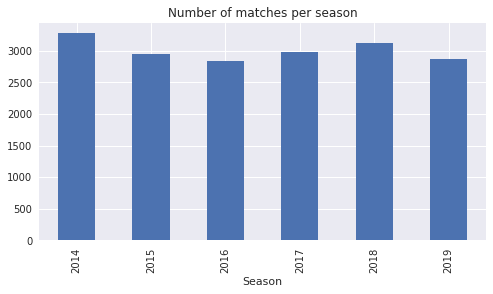

In [5]:
match_data.groupby('Season')['ID'].nunique()\
    .plot(kind='bar', title='Number of matches per season', figsize=(8,4))

Note: player 1 tends to be a higher ranking or more well-known player, whereas player 2 would more often contain qualifiers or amateur players breaking into eg. English Open. This is shown by the higher variety of unique players in player 2.

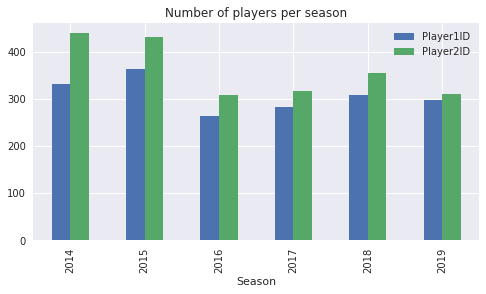

In [6]:
match_data.groupby('Season')[['Player1ID', 'Player2ID']].nunique()\
    .plot(kind='bar', title='Number of players per season', figsize=(8,4))

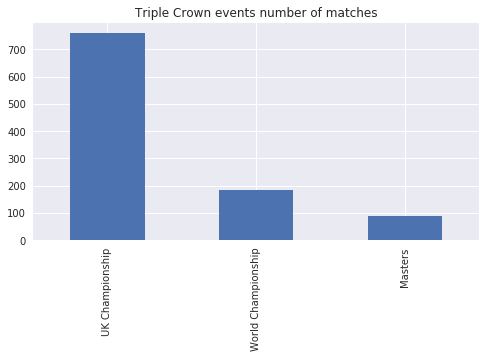

In [7]:
match_data.loc[match_data['Name'].isin(TRIPLE_CROWN_EVENTS), 'Name'].value_counts()\
    .plot(kind='bar', title='Triple Crown events number of matches', figsize=(8,4))

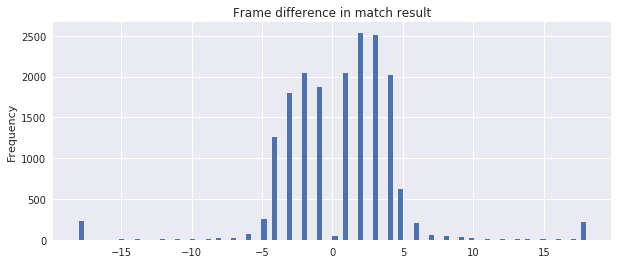

In [8]:
(match_data['Score1'] - match_data['Score2']).clip(-18, 18)\
    .plot(kind='hist', bins=100, title='Frame difference in match result', figsize=(10,4))

## Create some features

In [9]:
match_data['TripleCrown'] = (match_data['Name'].isin(['World Championship', 'UK Championship', 'Masters'])).astype(int)
match_data['BestOf'] = match_data[['Score1', 'Score2']].max(axis=1)*2 - 1
match_data['CountryEqualsPlayer1Nationality'] = (match_data['Player1Nationality'] == match_data['Country']).astype(int)
match_data['CountryEqualsPlayer2Nationality'] = (match_data['Player2Nationality'] == match_data['Country']).astype(int)

In [10]:
match_data['delta_seeding'] = match_data['Player1Seeding'] - match_data['Player2Seeding']
match_data['delta_YearsAsPro'] = match_data['Player1YearsAsPro'] - match_data['Player2YearsAsPro']
match_data['delta_LastSeasonRank'] = match_data['Player1LastSeasonRank'] - match_data['Player2LastSeasonRank']
match_data['delta_LastSeasonSum'] = match_data['Player1LastSeasonSum'] - match_data['Player2LastSeasonSum']

In [11]:
FULL_FEATURE_LIST = [
    'Country',
    'Type_event',
    'NumCompetitors',
    'Stage',
    'TripleCrown',
    'BestOf',
    'Player1Nationality',
    'Player2Nationality',
    'CountryEqualsPlayer1Nationality',
    'CountryEqualsPlayer2Nationality',
    'Player1Seeding',
    'Player2Seeding',
    'Player1YearsAsPro',
    'Player2YearsAsPro',
    'Player1LastSeasonRank',
    'Player2LastSeasonRank',
    'Player1LastSeasonSum',
    'Player2LastSeasonSum',
    'delta_seeding',
    'delta_YearsAsPro',
    'delta_LastSeasonRank',
    'delta_LastSeasonSum'
]

In [12]:
# match_data[FULL_FEATURE_LIST] = match_data[FULL_FEATURE_LIST].fillna(NULL_IMPUTATION_VALUE)

In [13]:
PROCESSED_FEATURE_LIST = FULL_FEATURE_LIST

for feature in FULL_FEATURE_LIST:
    if pd.to_numeric(match_data.loc[~match_data[feature].isnull(), feature], errors='coerce').isnull().sum() > 0:
        print('{} is not numeric! Encoding as one-hot...'.format(feature))
        match_data = pd.get_dummies(match_data, columns=[feature], prefix=feature)
        PROCESSED_FEATURE_LIST = PROCESSED_FEATURE_LIST + \
            [col for col in match_data.columns if col.startswith('{}_'.format(feature))]
        PROCESSED_FEATURE_LIST.remove(feature)

Country is not numeric! Encoding as one-hot...
Type_event is not numeric! Encoding as one-hot...
Stage is not numeric! Encoding as one-hot...
Player1Nationality is not numeric! Encoding as one-hot...
Player2Nationality is not numeric! Encoding as one-hot...


In [14]:
match_data[PROCESSED_FEATURE_LIST] = match_data[PROCESSED_FEATURE_LIST].fillna(NULL_IMPUTATION_VALUE)

## Feature importances

Use a simple decision tree and look at the most important features selected.

In [16]:
clf_1 = DecisionTreeClassifier(
    min_samples_leaf=0.005, 
    max_depth=3,
    random_state=RANDOM_SEED
)
clf_1.fit(
    match_data[PROCESSED_FEATURE_LIST], 
    match_data[TARGET_COL]
)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.005, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=12345, splitter='best')

In [17]:
clf_1_importances = pd.DataFrame({'Feature_importances': clf_1.feature_importances_}, index=PROCESSED_FEATURE_LIST)\
    .sort_values('Feature_importances', ascending=False).head(20)

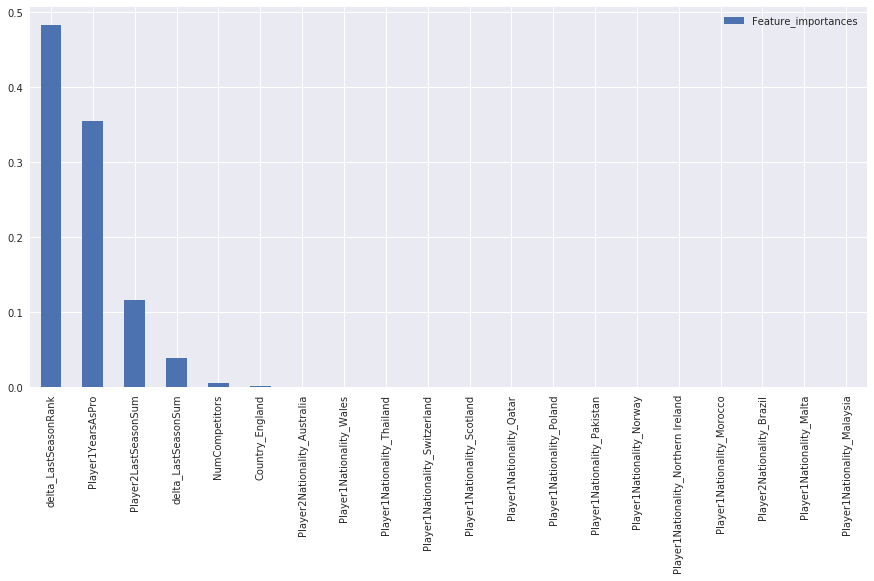

In [18]:
clf_1_importances.plot(kind='bar', figsize=(15, 7))

In [19]:
import re
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree


def plot_labelled_tree(estimator, features, shift=0, title=None, save=False, node_label=False):
    _, ax = plt.subplots(figsize=(18, 6))
    annotations = plot_tree(
        estimator,
        ax=ax,
        feature_names=features,
        proportion=True,
        node_ids=True,
        fontsize=10
    )

    leaf_nodes = [i for i, x in enumerate(estimator.tree_.feature) if x == -2]

    annotation_dict = {
        node_id: 'segment #{}'.format(segment+shift) for segment, node_id in enumerate(leaf_nodes)
    }

    n_nodes = estimator.tree_.node_count
    for i in range(n_nodes):
        for j in range(n_nodes-1, -1, -1):
            if node_label:
                continue
            else:
                annotations[i].set_text(
                    re.sub(
                        r'gini = 0.\d+\n', 
                        '',
                        annotations[i].get_text().replace('node #{}'.format(j), '{}'.format(
                            annotation_dict[j] if j in annotation_dict.keys() else ''
                        ))
                    )
                )
            
        if 'segment #' in annotations[i].get_text():
            annotations[i].get_bbox_patch().set_facecolor('lavender')
        else:
            annotations[i].get_bbox_patch().set_facecolor('aliceblue')
            
    if title:
        plt.title(title, fontsize=16)
        
    if save:
        plt.savefig('_'.join(title.split(' '))+'.png')
        
    plt.show()
    print('\n')

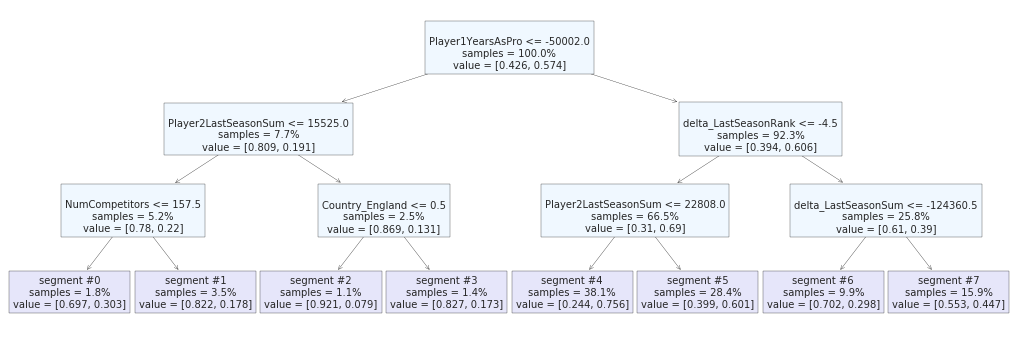

In [20]:
plot_labelled_tree(clf_1, PROCESSED_FEATURE_LIST)

When the player has `Player1YearsAsPro == -99999` (ie. null) then they are an amateur. For example:

In [21]:
pd.DataFrame(requests.get('http://api.snooker.org/?p={}'.format(146)).json())

,ID,Type,FirstName,MiddleName,LastName,TeamName,TeamNumber,TeamSeason,ShortName,Nationality,Sex,BioPage,Born,Twitter,SurnameFirst,License,Club,URL,Photo,PhotoSource,FirstSeasonAsPro,LastSeasonAsPro,Info
0,146,1,Oliver,,Brown,,0,0,O Brown,England,M,,1994-08-18,OliverBrown147,False,,,,,,0,0,


In [22]:
match_data.loc[match_data['Player1ID'] == 146, ['Player1ID', 'Player1YearsAsPro']].head(1)

,Player1ID,Player1YearsAsPro
26,146,-99999.0


## Feature importances: Univariate linear models

Try another method of extracting feature importances. Univariate logistic regression models and ROC AUC scores.

In [23]:
train_index, test_index = train_test_split(match_data.index, train_size=0.8, random_state=RANDOM_SEED)

In [24]:
feature_importances = {}
for feature in PROCESSED_FEATURE_LIST:
    univariate_model = LogisticRegression()
    univariate_model.fit(
        match_data.loc[train_index, feature].values.reshape(-1, 1), 
        match_data.loc[train_index, TARGET_COL].values
    )
    test_scores = univariate_model.predict_proba(match_data.loc[test_index, feature].values.reshape(-1, 1))[:, 0]
    feature_importances[feature] = roc_auc_score(match_data.loc[test_index, TARGET_COL].values, test_scores) - 0.5 

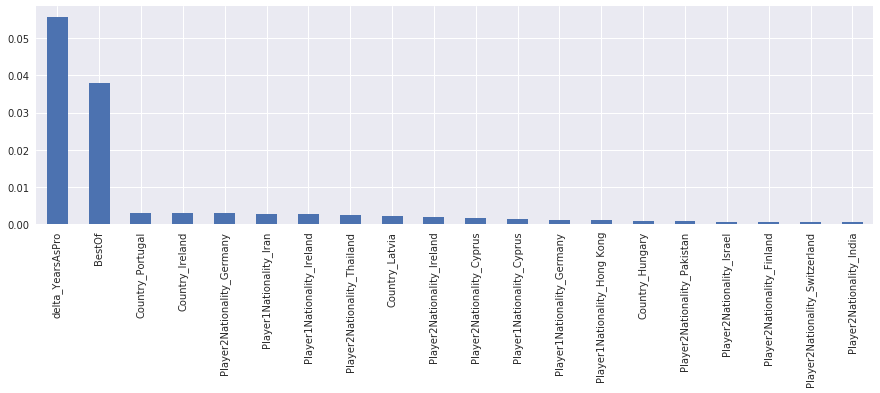

In [25]:
pd.Series(feature_importances).sort_values(ascending=False).head(20).plot(kind='bar', figsize=(15,4))